In [1]:
import os
import time

# pip/conda installed
import dask.array as da
import fsspec
import pandas as pd
import xarray as xr
from dask.distributed import as_completed
from dask.distributed import Client
from dask_gateway import GatewayCluster

from utils import get_logger
from utils.dask import create_cluster
from utils.dask import upload_source
from utils.hls.catalog import HLSBand
from utils.hls.catalog import HLSCatalog
from utils.hls.catalog import scene_to_urls
from utils.hls import compute

In [2]:
logger = get_logger('hls-masked-monthly-median-qa')

In [3]:
# fill with your account key
os.environ['AZURE_ACCOUNT_KEY'] = ""

In [4]:
# read the entire data once (each tile is 3660x3660)...
chunks = {'band': 1, 'x': 3660, 'y': 3660}

In [5]:
bands = [HLSBand.NIR_NARROW, HLSBand.QA]
seattle_df = pd.DataFrame([{'lat': 47.6062, 'lon': -122.3321, 'year': 2018}])
catalog = HLSCatalog.from_point_pandas(seattle_df, bands)
catalog.xr_ds

Reading tile extents...
Read tile extents for 56686 tiles


<xarray.Dataset>
Dimensions:  (index: 172)
Coordinates:
  * index    (index) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
Data variables:
    lat      (index) float64 47.61 47.61 47.61 47.61 ... 47.61 47.61 47.61 47.61
    lon      (index) float64 -122.3 -122.3 -122.3 ... -122.3 -122.3 -122.3
    year     (index) int64 2018 2018 2018 2018 2018 ... 2018 2018 2018 2018 2018
    tile     (index) object '10TET' '10TET' '10TET' ... '10TET' '10TET' '10TET'
    scene    (index) object 'L30/HLS.L30.T10TET.2018006.v1.4' ... 'S30/HLS.S3...
    sensor   (index) object 'L' 'L' 'L' 'L' 'L' 'L' ... 'S' 'S' 'S' 'S' 'S' 'S'
    dt       (index) datetime64[ns] 2018-01-06 2018-01-13 ... 2018-12-29
Attributes:
    bands:    [<HLSBand.NIR_NARROW: 5>, <HLSBand.QA: 11>]

In [6]:
cluster = create_cluster(
    workers=6,
    worker_threads=1,
    worker_memory=6,
    scheduler_threads=4,
    scheduler_memory=8
)
client = cluster.get_client()
cluster

In [7]:
from importlib import reload

reload(compute)
# All workers must be started when source code is uploaded to them.
upload_source('./utils', client)

In [8]:
account_name="usfs"
storage_container="fia/hls/qa"
account_key=os.environ["AZURE_ACCOUNT_KEY"]
catalog_groupby = "tile"
job_groupby = "time.month"

In [9]:
compute.process_catalog(
    catalog=catalog.xr_ds,
    catalog_groupby=catalog_groupby,
    job_fn=compute.calculate_job_median,
    job_groupby=job_groupby,
    chunks=chunks,
    account_name=account_name,
    storage_container=storage_container,
    account_key=account_key,
    client=client,
    concurrency=1,
    logger=logger
)

2021-01-08 01:13:22,123 [INFO] hls-masked-monthly-median-qa - Submitting job 10TET
2021-01-08 01:15:05,687 [INFO] hls-masked-monthly-median-qa - Completed job 10TET
2021-01-08 01:15:05,688 [INFO] hls-masked-monthly-median-qa - 1 completed in 103.56675494404044 seconds


In [10]:
cluster.shutdown()

In [12]:
tile_path = fsspec.get_mapper(
    f"az://fia/hls/qa/10TET.zarr",
    account_name="usfs",
    account_key=os.environ['AZURE_ACCOUNT_KEY']
)
tile = xr.open_zarr(tile_path)
tile

<xarray.Dataset>
Dimensions:     (month: 12, x: 3660, y: 3660)
Coordinates:
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * x           (x) float64 5e+05 5e+05 5.001e+05 ... 6.097e+05 6.098e+05
  * y           (y) float64 5.3e+06 5.3e+06 5.3e+06 ... 5.19e+06 5.19e+06
Data variables:
    NIR_NARROW  (month, y, x) float64 dask.array<chunksize=(1, 3660, 3660), meta=np.ndarray>

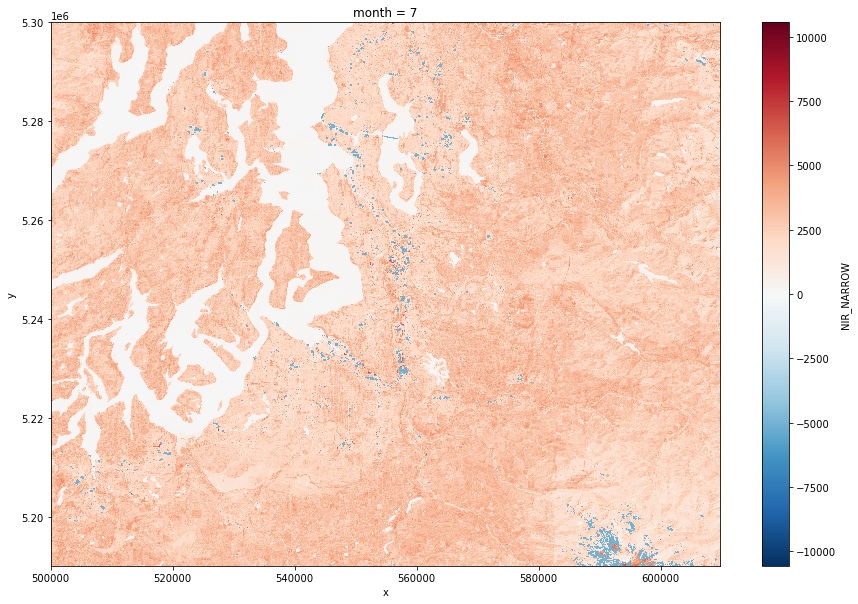

In [13]:
tile.sel(month=7)['NIR_NARROW'].fillna(-5000).plot.imshow(size=10)